In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('all_faults.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [4]:
X.shape

(9246, 784, 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [28]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import concatenate

# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')
import tensorflow
tensorflow.config.run_functions_eagerly(True)

no_classes = len(df['fault'].unique())
#head 1
inputs1 = Input(shape=(X.shape[1],X.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)
# head 2
inputs2 = Input(shape=(X.shape[1],X.shape[2]))
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)
# head 3
inputs3 = Input(shape=(X.shape[1],X.shape[2]))
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

# Plot Model
cnn_model.summary()
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 585, 64)      12864       input_22[0][0]                   
______________________________________________________________________________________

In [29]:
batch_size =100
epochs = 5
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

C:\Users\mohan\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/5
65/65 [==============================] - 30s 466ms/step - loss: 1.3168 - accuracy: 0.5944 - val_loss: 0.6039 - val_accuracy: 0.9146
Epoch 2/5
65/65 [==============================] - 30s 466ms/step - loss: 0.1800 - accuracy: 0.9529 - val_loss: 0.2007 - val_accuracy: 0.9805
Epoch 3/5
65/65 [==============================] - 30s 466ms/step - loss: 0.0591 - accuracy: 0.9873 - val_loss: 0.1406 - val_accuracy: 0.9838
Epoch 4/5
65/65 [==============================] - 30s 468ms/step - loss: 0.0502 - accuracy: 0.9907 - val_loss: 0.1077 - val_accuracy: 0.9874
Epoch 5/5
65/65 [==============================] - 30s 463ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.0680 - val_accuracy: 0.9942


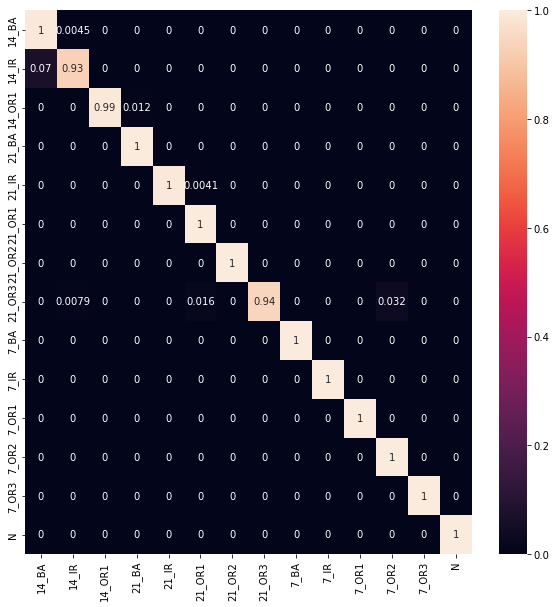

In [31]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [36]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

In [37]:
y_viz.shape

(6472, 100)

C:\Users\mohan\.conda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.000s...
[t-SNE] Computed neighbors for 6472 samples in 1.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.365071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.463463
[t-SNE] KL divergence after 300 iterations: 1.816120


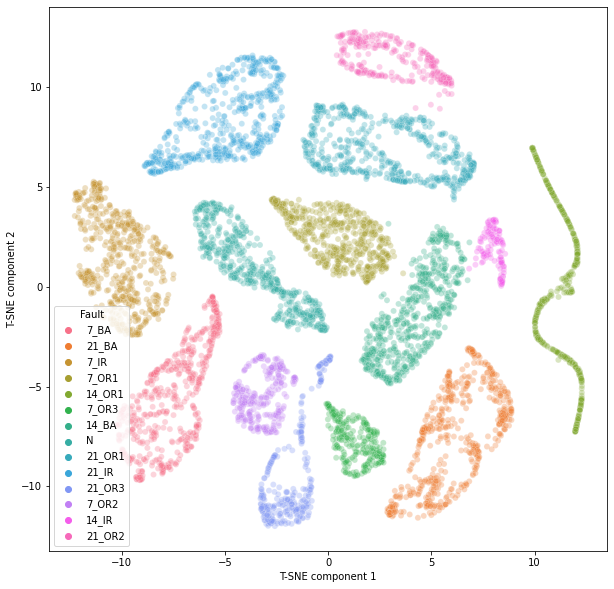

In [38]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()